# Showing the difference between when the observational limits are applied using a truncated normal distribution vs cutting the data points out all together

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

## Simulating data following the steps in hierarchical_model_steps.ipynb

In [2]:
# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

In [3]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_ang_max = 4.0
sep_ang_min = 0.1


# limit for contrast ratio
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    return 1.8 * np.log(separation) + 3.8

In [4]:
# Sample of 2000
n = 2000

In [5]:
# SEPARATIONS (AU)

# Gamma distribution
# Defining gamma mean and variance - pymc3
gamma_mean = 40
gamma_width = 30
# Defining gamma alpha and beta - pymc3
gamma_a = gamma_mean**2 / gamma_width**2
gamma_b = gamma_mean / gamma_width**2
# Defining gamma shape (k) and scale (theta) - np.random.gamma
k = gamma_a
theta = 1/gamma_b

sep_physical = np.random.gamma(k, theta, size=n)

simulated_data_df = pd.DataFrame({'sep_physical':sep_physical})

In [6]:
# INVERTED MASS RATIOS

# Define Pareto shape (a) and scale/minimum (m)
a = 1.2
m = 1

mass_ratios_inverted = (np.random.pareto(a, size=n) + 1)*m

simulated_data_df['mass_ratios_inverted'] = mass_ratios_inverted

In [7]:
# DISTANCES (PARSECS)
# Limiting to 100 pc around us, the distances should follow a power law with index 2, as n increases with r^2
dist_physical  = np.random.power(2, size=n)*100               # in parsecs   
simulated_data_df['dist_physical'] = dist_physical

# PARALLAX
simulated_data_df['dist_parallax'] = 1/simulated_data_df['dist_physical']

In [8]:
# TRANSFORM TO ANGULAR SEPARATIONS
simulated_data_df['sep_angular'] = simulated_data_df['sep_physical'] / simulated_data_df['dist_physical']

# TRANSFORM TO INVERSE CONTRAST RATIOS
simulated_data_df['contrast_ratios_inverted'] = imr_to_icr(mass_ratios_inverted)

In [9]:
# ADD ERRORS FOR MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS
# Separations
simulated_data_df['sep_ang_e'] = 0.07

# Contrasts
cr_err = np.random.random_sample((len(simulated_data_df),))/10
simulated_data_df['cr_err'] = (cr_err/(simulated_data_df['sep_angular']))*np.random.random()

In [10]:
# MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS
simulated_data_df['sep_measured'] = np.random.normal(loc=simulated_data_df['sep_angular'], scale=simulated_data_df['sep_ang_e'])
simulated_data_df['cr_measured'] = np.random.normal(loc=1/simulated_data_df['contrast_ratios_inverted'], scale = simulated_data_df['cr_err'])

## This is where the sample truncated using a truncated normal distribution starts to differ from the sample with the un-observable points cut out

In [11]:
# OBSERVED SEPARATIONS (WITH OBSERVATIONAL LIMITATIONS AS TRUNCATED NORM)

# Need to calculate a and b (inputs for stats.truncnorm) for our desired distribution
myclip_a = sep_ang_min
myclip_b = sep_ang_max
my_mean = simulated_data_df['sep_measured']
my_std = simulated_data_df['sep_ang_e']
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

simulated_data_df['sep_observed'] = stats.truncnorm.rvs(a=a, b=b, loc=my_mean, scale=my_std)

In [13]:
# OBSERVED CONTRAST RATIOS (WITH OBSERVATIONAL LIMITATIONS AS TRUNCATED NORM)

# Need to calculate a and b (inputs for stats.truncnorm) for our desired distribution
myclip_a = 0
myclip_b = cr_max(simulated_data_df['sep_observed'])
my_mean = simulated_data_df['cr_measured'].values
my_std = simulated_data_df['cr_err'].values
a,b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
 
cr_observed = []

for i in range(len(a)):
# Calculating the lower limit with cr_max sometime yields a negative result
# and the truncnorm function only works if the lower limit < upper limit
    if a[i] < b[i]:
#         print(i)
        cr_observed.append(stats.truncnorm.rvs(a=a[i], b=b[i], loc=my_mean[i], scale=my_std[i]))
    else:
#         print(a[i],b[i])
#         print('else')
        cr_observed.append(stats.truncnorm.rvs(a=0, b=np.abs(b).min(), loc=my_mean[i], scale=my_std[i]))
        
### Sometimes this throws an error that it didn't converge, try a few more times and it'll run ###

In [14]:
simulated_data_df['cr_observed'] = cr_observed

In [15]:
# CUTTING DATA OUTSIDE OF THE OBSERVABLE RANGE

# Make a new dataframe that discludes cr_measured and sep_measured that fall out of the observable range
simulated_data_cut = simulated_data_df.loc[(simulated_data_df['sep_measured']<sep_ang_max) & (simulated_data_df['sep_measured']>sep_ang_min) & (simulated_data_df['cr_measured']<cr_max(simulated_data_df['sep_observed']))]

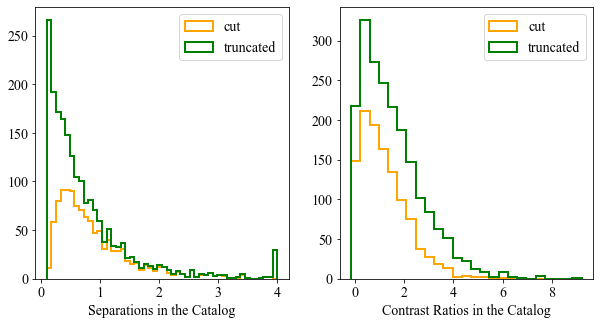

In [16]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = [plt.subplot(121), plt.subplot(122)]

ax1.set_xlabel('Separations in the Catalog')
ax1.hist([simulated_data_df['sep_observed'],simulated_data_cut['sep_observed']],bins=50,histtype='step',label=['truncated','cut'],color=['g','orange'], linewidth=2);
ax1.plot()
ax1.legend()

ax2.set_xlabel('Contrast Ratios in the Catalog')
ax2.hist([simulated_data_df['cr_observed'],simulated_data_cut['cr_observed']],bins=25,histtype='step',label=['truncated','cut'],color=['g','orange'], linewidth=2);
ax2.legend()

## ^ Note the pile up at the lowest and highest separations
I'm not sure that I'm handling the truncation of the contrast ratios correctly, but this exercise still show that sampling the observed points (which appear in the final catalog) is not the best way to truncate the data. Sampling the observed points from a truncated distribution forces points with physical parameters which would deem them un-observable to appear in the final catalog. For the separations, we can see that the outlier points end up at the edges of the observable space.

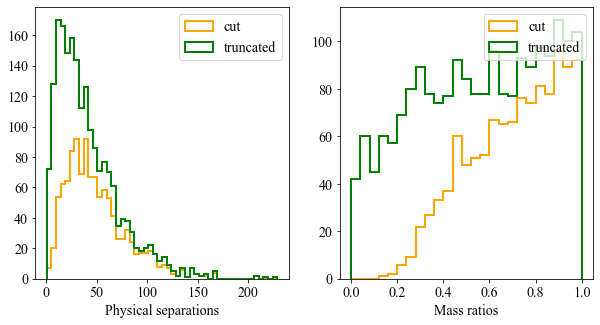

In [17]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = [plt.subplot(121), plt.subplot(122)]

ax1.set_xlabel('Physical separations')
ax1.hist([simulated_data_df['sep_physical'],simulated_data_cut['sep_physical']],bins=50,histtype='step',label=['truncated','cut'],color=['g','orange'], linewidth=2);
ax1.plot()
ax1.legend()

ax2.set_xlabel('Mass ratios')
ax2.hist([1/simulated_data_df['mass_ratios_inverted'],1/simulated_data_cut['mass_ratios_inverted']],bins=25,histtype='step',label=['truncated','cut'],color=['g','orange'], linewidth=2);
ax2.legend()

Compared to our model fits vs the input parameters:

Again, I'm not confident in how I am truncating the contrast ratios, but I think this still displays the issue

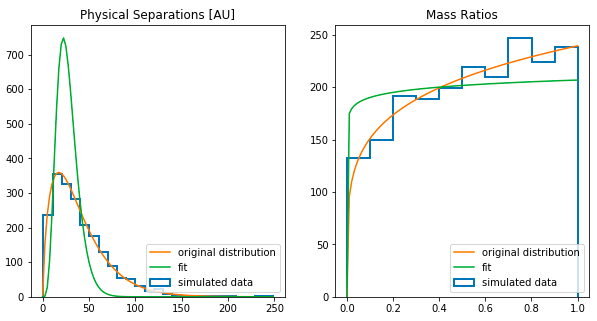

In [18]:
from IPython.display import Image 
Image("modelfits.png")